In [18]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from PIL import Image

import gym

import torch
import torch.optim as optim
import torch.nn.functional as F

from model import QNet

%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()

if use_cuda:
    print('Using GPU!')
else:
    print('Using CPU! Recommend moving to GPU for training!')

Using CPU! Recommend moving to GPU for training!


I plan to use an EC2 p2.xlarge instance to train the model

In [3]:
#Create the Breakout environment with each action being repeated over 4 frames
env = gym.make('BreakoutDeterministic-v4')
env.seed(0)

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n

print('State shape: ', STATE_SHAPE)
print('Actions: ', NUM_ACTIONS)

State shape:  (210, 160, 3)
Actions:  4


In [4]:
class ReplayMem():
    """
        Memory to store recent transitions undergone by the agent for future use
        ARGS:
        capacity:= maximum number of transitions to keep in memory
        num_actions:= number of actions in the environment
        batch_size:= size of each training batch
        seed:= random seed
        device('cuda', 'cpu'):= device used for agent
    """
    def __init__(self, capacity, num_actions, batch_size, seed, device):
        self.memory = deque(maxlen=capacity)
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        self.device = device
        
    def push(self, state, action, reward, next_state, done):
        """
            Saves a transition to the memory
        """
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
        
    def sample(self):
        """
            Randomly sample specified number of transitions from the memory
            ARGS:
            n_samples:= number of samples to pull, without replacement
            RETURN:
            n_samples number of transitions
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float().to(self.device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [26]:
class Agent():
    """
        Agent to interact with and learn from the chosen environment
        ARGS:
        num_actions:= number of valid actions the agent can choose from in the environment
        batch_size:= number of 
        seed:= random seed
        cuda(boolean):= boolean describing if gpu is available for use
        mem_cap:= max number of recent experiences the agent will store for experience replay
        lr:= learning rate
        gamma:= discount factor
        tau:= for soft update of target parameters
        update_every:= number of steps before the target_net is updated with the policy_net params
    """
    def __init__(self, num_actions, batch_size, seed, cuda, mem_cap, lr, gamma, tau, update_every):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every
        
        if cuda:
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        
        self.policy_net = QNet().to(self.device)
        self.target_net = QNet().to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        
        self.memory = ReplayMem(capacity=mem_cap,
                                num_actions=num_actions,
                                batch_size=batch_size,
                                seed=seed,
                                device=self.device)
        
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, preprocess_frames(next_state), done)
        
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
                
    def choose_action(self, state, eps=0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)
        self.policy_net.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.num_actions))
        
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        
        Q_target_next = self.target_net(next_states.unsqueeze(1)).detach().max(1)[0].unsqueeze(1)
        Q_target = rewards + (self.gamma * Q_target_next * (1 - dones))
        
        Q_expected = self.policy_net(states.unsqueeze(1)).gather(1, actions)
        
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.policy_net, self.target_net)
        
    def soft_update(self, policy_net, target_net):
        for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)

In [27]:
def preprocess_frames(state):
    """
        Convert a game frame to an 84x84 grayscale image
    """
    image = np.reshape(state, [210, 160, 3]).astype(np.float32)
    image = image[:,:,0] * 0.299 + image[:,:,1] * 0.587 + image[:,:,2] * 0.114
    image = Image.fromarray(image)
    screen = image.resize((84,110), Image.CUBIC)
    screen = np.array(screen)
    play_area = screen[18:102,:]
    play_area = play_area / 255.0
    play_area = np.expand_dims(play_area, 0)
    return play_area

In [37]:
#Hyperparameters, optimizer, and loss, taken from paper Hasselt et al. 2015
BATCH_SIZE = 32
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
MEMORY = 100000 #Paper says 1M frames, however, due to memory constraints we will use fewer
GAMMA = 0.99
LR = 0.00025
TAU = 0.001
UPDATE_EVERY = 4

In [40]:
agent = Agent(num_actions=NUM_ACTIONS,
              batch_size=BATCH_SIZE, 
              seed=314, 
              cuda=use_cuda, 
              mem_cap=MEMORY,
              lr=LR, 
              gamma=GAMMA, 
              tau=TAU, 
              update_every=UPDATE_EVERY)

In [41]:
#Test that everything works and observe an untrained agent
state = env.reset()
for i in range(200):
    state = preprocess_frames(state)
    action = agent.choose_action(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break
        
env.close()

In [42]:
def train(agent, n_episodes, max_t, eps_start, eps_end, eps_decay, freq):
    """
        Train the agent using Double Deep Q Learning
        ARGS:
        agent(Agent):= instance of agent that will be trained
        n_episodes:= maximum number of training episodes
        max_t:= maximum number of time steps per training episode
        eps_start:= initial epsilon value (epsilon-greedy)
        eps_end:= minimum epsilon value
        eps_decay:= decay rate of epsilon value
        freq:= frequency of showing average score
        RETURN:
        list of scores
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for ep in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            state = preprocess_frames(state)
            action = agent.choose_action(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode: {} \tAverage Score: {:.2f}'.format(ep, np.mean(scores_window)), end="")
        
        if ep % freq == 0:
            print('\rEpisode: {} \tAverage Score: {:.2f}'.format(ep, np.mean(scores_window)))
            
    return scores

In [43]:
scores = train(agent, 50, 1000, EPS_START, EPS_END, EPS_DECAY, 10)

Episode: 10 	Average Score: 1.30
Episode: 20 	Average Score: 1.10
Episode: 30 	Average Score: 1.30
Episode: 40 	Average Score: 1.38
Episode: 50 	Average Score: 1.34


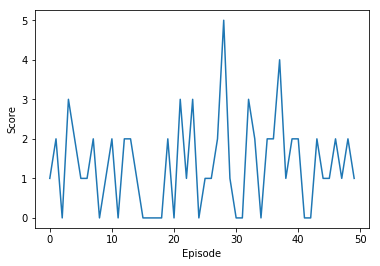

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [46]:
#Watch the trained agent play
state = env.reset()
for i in range(1000):
    state = preprocess_frames(state)
    action = agent.choose_action(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break
        
env.close()